In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from scipy.stats import pearsonr

file_vwnd = './vwnd.mon.mean.nc'
file_uwnd = './uwnd.mon.mean.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)
# vwnd(time, level, lat, lon) current shape = (904, 17, 73, 144)
vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']


cor_num = pd.read_excel(io = r'./ACEWP.xlsx')
coordinate = cor_num['WP'].tolist()


In [283]:
vlat

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    actual_range: [ 90. -90.]
    long_name: Latitude
    standard_name: latitude
    axis: Y
unlimited dimensions: 
current shape = (73,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
# 求level在850处的涡度
# |delta v / |delta x - |delta u / |delta y
# 因为纬度lat有地球偏差 x = x * cos(lat) * 111
# 每一年计算一个涡度，每个点在时间序列上有40个涡度值
# 对每个点进行相关计算
vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]

In [205]:
# 计算相邻两点之间的绝对距离
lat = vlat[:].data
Y_derivative = abs((lat[2]-lat[0])*111)
lon = vlon[:].data
X_derivative = (lon[2]-lon[0])*111
print(X_derivative, Y_derivative)

# 计算涡度需要上面那个点 因此上下都多一行
# vwind_mid = vwnd[:1,2:3,18:55,:].data[0][0] 
vwind_mid = vwnd[:1,2:3,17:56,:].data[0][0] 
uwind_mid = uwnd[:1,2:3,17:56,:].data[0][0] 

555.0 555.0


In [288]:
for i in range(lat.shape[0]):
    if lat[i] == 45.0 or lat[i] == -45.0:
        print(i)

18
54


In [213]:
def X_vorticity(vwind_mid):
    # 计算每个点的涡度 X_vorticity = dv / dx
    X_vorticity = np.zeros((37,144), dtype=float, order='C')
    # 从第1行计算到倒数第二行的涡度
    for row in range(1, vwind_mid.shape[0]-1):
        # 在row行的风数值
        vwind_lat = vwind_mid[row]
        # row行的lat纬度值
        row_lat = lat[row+17]
    #     print(row, row+17)
        X_dis = X_derivative*math.cos(math.radians(lat[row+17]))
        for i in range(len(vwind_lat)):
            if i<=len(vwind_lat)-2:
                X_vorticity[row-1][i] = (vwind_lat[i+1]-vwind_lat[i-1])/X_dis
            elif i == len(vwind_lat)-1:
                X_vorticity[row-1][i] = (vwind45[len(vwind_lat)-i]-vwind_lat[i-1])/X_dis
    return X_vorticity

def Y_vorticity(uwind_lat):
    # 计算 Y_vorticity = du/dy
    # 对于第一行的涡度，用第三行减去第一行，除以距离
    Y_vorticity = np.zeros((37,144), dtype=float, order='C')
    for i in range(1, 38):
        Y_vorticity[i-1] = (uwind_lat[i]-uwind_lat[i-2])/Y_derivative
    return Y_vorticity

In [210]:
def num_month(a):
    '''
    计算循环的起始年，结束年
    '''
    if a == 1982:
        num_months = (1982 - 1948 + 1) * 12 
        num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
        start = num_months
        end = start + num_month_1997to1982
    elif a == 1998:
        start = (1998 - 1948 + 1) * 12 + 1
        num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数
        end = start + num_month_2021to1998
    else:
        print("Input must be 1982 or 1998!")
    return start, end

start_82, end_82 = num_month(1982)
start_98, end_98 = num_month(1998)

In [284]:
# 以一年为基础 计算年平均涡度 先求涡度 再计算平均涡度
def vorticity(start, end):
    # start开始月份 end结束月分，num_month
    if (end-start) % 12 != 0:
        return print("Error! The input must be the month of a year")
    num_month = int((end-start)/12)
    vorticity_year = np.zeros((num_month,37,144), dtype=float, order='C')
    for i in range(start, end, 12):
        tmp_vorticity_year = np.zeros((37,144), dtype=float, order='C')
        for j in range(12):
            month = i+j
            vwind_mid_tmp = vwnd[month:month+1,2:3,17:56,:].data[0][0]
            X_vorticity_tmp = X_vorticity(vwind_mid_tmp)  
            uwind_mid_tmp = uwnd[month:month+1,2:3,17:56,:].data[0][0] 
            Y_vorticity_tmp = Y_vorticity(uwind_mid_tmp)
            vorticity_tmp = X_vorticity_tmp - Y_vorticity_tmp
            tmp_vorticity_year += vorticity_tmp

        vorticity_mean = tmp_vorticity_year / 12
        index = int((i-start)/12)
        vorticity_year[index] = vorticity_mean
    return vorticity_year

def PearsonMatrix(reshape_mean):
    pearson_matrix = np.zeros((37,144), dtype=float, order='C')
    p_value = np.zeros((37,144), dtype=float, order='C')
    for i in range(len(reshape_mean)):
        for j in range(len(reshape_mean[i])):
            x = reshape_mean[i][j]
            if len(x) == 16:
                y = coordinate[:16]
            elif len(x) == 24:
                y = coordinate[16:]
            else:
                print("Error, the dimension x and y ")
            tmp_correlation, _ = pearsonr(x, y)
    #         print(tmp_correlation)
            pearson_matrix[i][j] = tmp_correlation
            p_value[i][j] = _
    pearson_matrix = np.nan_to_num(pearson_matrix)
    return pearson_matrix, p_value

In [285]:
vorticity_1982to1997 = vorticity(start_82, end_82).transpose(1,2,0)
vorticity_1998to2022 = vorticity(start_98, end_98).transpose(1,2,0)

In [272]:
vorticity(start_82, end_82)[0].shape

(37, 144)

In [286]:
pearson_matrix_1997to1982, p_value_1997to1982 = PearsonMatrix(vorticity_1982to1997)
pearson_matrix_1998to2021, p_value_1998to2021 = PearsonMatrix(vorticity_1998to2022)

print(pearson_matrix_1997to1982.max(), pearson_matrix_1997to1982.min())
print(pearson_matrix_1998to2021.max(), pearson_matrix_1998to2021.min())

0.851005132663281 -0.8312399089901533
0.7781076703038852 -0.7539309004455846


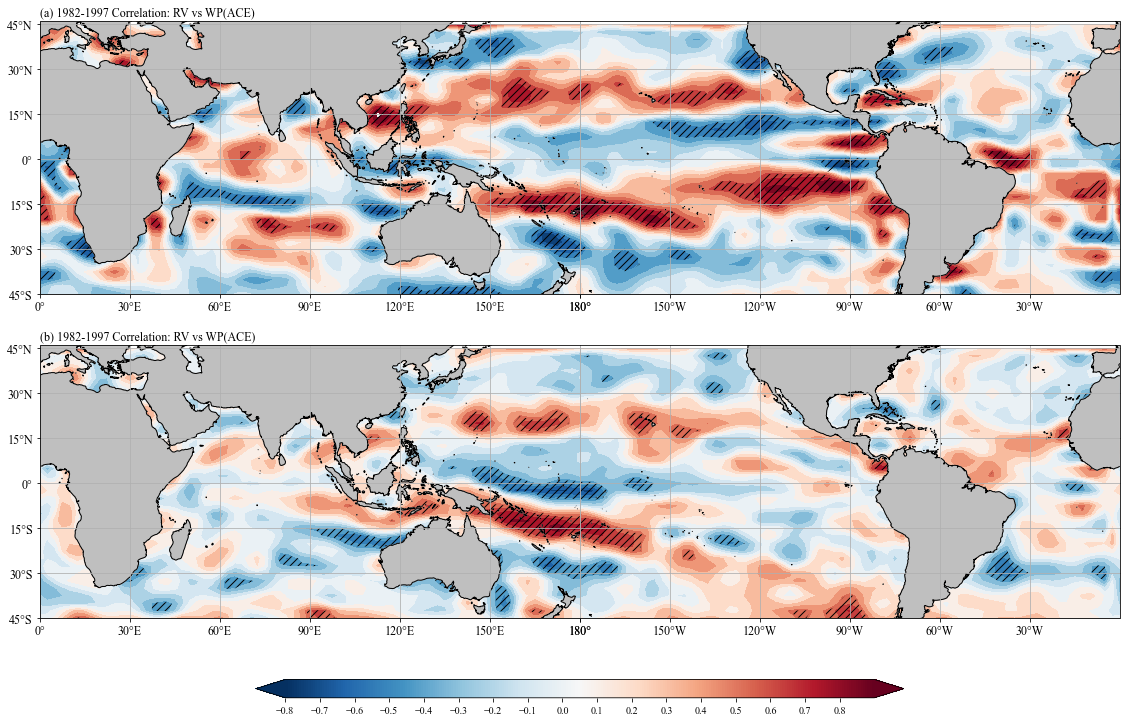

In [291]:
from matplotlib.font_manager import FontProperties

plt.rc('font',family='Times New Roman') 
# 纬度转换成太平洋为中心，增加360度一度
lon = np.append(vlon[:].data, [360.0])
# lon = vlon[:].data
# 取经度数据
lat = vlat[18:55].data

# new_diff = pearson_matrix
diff_2d = pearson_matrix_1997to1982
# print(diff_2d)
# 对diff进行转换本初子午线为中心 为 太平洋为中心
new_diff_1988to1997=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff_1988to1997.append(tmp.tolist())
new_diff_1988to1997 = np.array(new_diff_1988to1997)

MAX = 0.9
MIN = -0.8

fig = plt.figure(figsize=(15,15))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (-180, 180.1, -45, 46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0.3, 1, 1], projection = proj)

fig_ax1.contourf(vlon[:].data, lat, p_value_1997to1982,
                [np.nanmin(p_value_1997to1982), 0.05, np.nanmax(p_value_1997to1982)],
#                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree()) # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,180.1,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) 1982-1997 Correlation: RV vs WP(ACE)',loc='left',fontsize =12)

cont_ax1 = fig_ax1.contourf(lon, lat, new_diff_1988to1997, 
                 levels=np.arange(MIN,MAX,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

# ======================= 图2 =============================
diff_3d = pearson_matrix_1998to2021
# print(diff_2d)
# 对diff进行转换本初子午线为中心 为 太平洋为中心
new_diff_1998to2021=[]
for i in range(diff_3d.shape[0]):
    tmp = np.append(diff_3d[i], diff_3d[i][0])
    new_diff_1998to2021.append(tmp.tolist())
new_diff_1998to2021 = np.array(new_diff_1998to2021)

fig_ax2 = fig.add_axes([0, 0, 1, 1], projection = proj)

fig_ax2.contourf(vlon[:].data, lat, p_value_1998to2021,
                [np.nanmin(p_value_1998to2021), 0.05, np.nanmax(p_value_1998to2021)],
#                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree()) # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(np.arange(-180,180.1,30), crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax2.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(b) 1982-1997 Correlation: RV vs WP(ACE)',loc='left',fontsize =12)

cont_ax1 = fig_ax2.contourf(lon, lat, new_diff_1998to2021, 
                 levels=np.arange(MIN,MAX,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

position = fig.add_axes([0.2, 0.3, 0.6, 0.017]) # 最下面位置

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
                                      ),
                 cax = position,
                 orientation='horizontal',
                 ticks=np.arange(MIN,MAX,0.1).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.012) 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
fc1.set_label(label="", fontdict=font) #设置colorbar的标签字体及其大小

plt.savefig("wnd_vorticity_2phase.png",dpi=300,bbox_inches='tight')
plt.show()